In [939]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.optimize import minimize
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.style.use("science")

In [940]:
SNR = 5.098 # known from original fits file
galfit_data = fits.open("../data/blocks1.fits")
im = galfit_data[3].data
wcs= WCS(galfit_data[1].header)
psf = fits.open("../data/rxj1131_psf1.fits")[0].data
im[im < 0] = 0

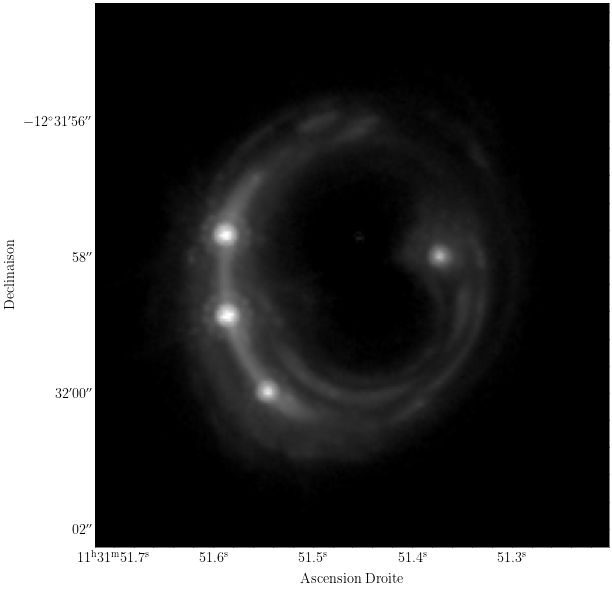

In [941]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(im, cmap="gray", norm=ImageNormalize(stretch=LogStretch()))#, norm=ImageNormalize(stretch=SqrtStretch()))
ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');

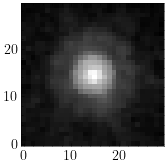

In [942]:
plt.imshow(psf, cmap="gray", norm=ImageNormalize(stretch=LogStretch()), origin="lower")

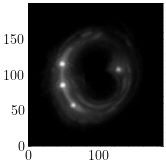

In [943]:
# further remove the central pixels for fitting
good_pixel_map = np.ones_like(im)
good_pixel_map[90:120, 80:106] = 0
plt.imshow(im * good_pixel_map, cmap="gray", norm=ImageNormalize(stretch=LogStretch()), origin="lower")#, norm=ImageNormalize(stretch=SqrtStretch()))

In [990]:
# source_grid
# lens_grid

def NIE_forward_model(params, intensity, source_grid, lens_grid):
    x0l, y0l, e, phi, x_c, r_ein, x0, y0, width = params
    # x0l : ra of lens (in as)
    # y0l: dec of lens (in as)
    # r_ein: Einstein radius (in mas)
    # e: ellipticity parameter
    # phi: orientation of the lens [0, pi]
    # x_c: central radius
    # x0, y0: position of the source
    # width: width of the source
    def psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        return np.sqrt(1/(1 - e)*theta1**2 + (1 - e)*theta2**2 + x_c)

    def grad_psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        p = psi(grid)
        grad1 = r_ein * theta1 / p / (1 - e)
        grad2 = r_ein * (1 - e) * theta2 / p
        return np.column_stack([grad1, grad2])

    def rotate(grid, phi):
        rho = np.hypot(grid[:, 0], grid[:, 1])
        varphi = np.angle(grid[:, 0] + 1j*grid[:, 1]) - phi
        rotated_theta1 = rho * np.cos(varphi)
        rotated_theta2 = rho * np.sin(varphi)
        return np.column_stack([rotated_theta1, rotated_theta2])

    def source_model(source_grid, intensity, x0, y0, width): # symmetric gaussian profile
        rho = np.hypot(source_grid[:, 0] - x0, source_grid[:, 1] - y0)
        return intensity * np.exp(-0.5*rho**2/width**2)/2/np.pi/width**2
    
    theta = rotate(lens_grid, phi)
    theta1 = theta[:, 0] - x0l
    theta2 = theta[:, 1] - y0l
    lens_grid = np.column_stack([theta1, theta2])
    
    alpha = grad_psi(lens_grid) # deflection angles
    beta  = theta - alpha # lens equation
    I     = source_model(source_grid, intensity, x0, y0, width)
    I_lens = griddata(source_grid, I, (beta[:, 0], beta[:, 1]), method="linear") # ray trace source profile to lens plane
    return I_lens
    
def likelihood(params, image, sigma_vector, psf, intensity, source_grid, lens_grid, pixel_map):
    I_reconstructed = NIE_forward_model(params, intensity, source_grid, lens_grid)
#     I_reconstructed += np.random.normal(0, sigma_vector.ravel(), size=I_reconstructed.shape)
    I_reconstructed = convolve2d(I_reconstructed.reshape(image.shape), psf, mode="same").ravel()
    chi_squared = 0.5 * np.mean((I_reconstructed[pixel_map] - image.ravel()[pixel_map])**2/(sigma_vector)**2)
    return chi_squared


<ipython-input-1009-d790400b3181>:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(good_pixel_map * im))


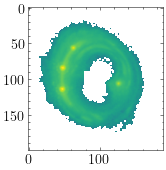

In [1009]:
#lensgrid -> place center in the bottom left corner, not in the center of the image
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)

good_pixels_map = np.zeros_like(rho, dtype=bool)
good_pixels_map[(rho > 25) & (rho < 200)] = True 
plt.imshow(np.log(good_pixel_map * im))

In [1010]:
# sky coordinate are relative to corner in pixel space
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
# place center in the middle of the array
x_lens = (lens_sky.ra - lens_sky.ra[M//2]).to(u.arcsec).value
y_lens = (lens_sky.dec - lens_sky.dec[M * N // 2]).to(u.arcsec).value
lens_grid = np.column_stack([x_lens.ravel(), y_lens.ravel()])
rho_lens = np.hypot(x_lens, y_lens)
fov = 2 * rho_lens.max()
fov

11.106699410950242

In [1011]:
# make fov of source plane about half as small
fov_source = fov/2
# source grid
Ns = N//2 # also make grid with about 4 times less pixel
Ms = M//2
ys = np.linspace(-1, 1, Ns) * fov_source
xs = np.linspace(-1, 1, Ms) * fov_source
xs, ys = np.meshgrid(xs, ys)
source_grid = np.column_stack([xs.ravel(), ys.ravel()])

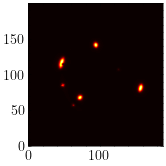

In [1012]:
# test forward, try to find a warm start
x0l = 0.1
y0l = 0
e = 0.3
phi = 0.3
x_c = 0.1
r_ein = 2
x0 = -0.3
y0 = 0
width = 0.01
intensity = im.sum()
params = x0l, y0l, e, phi, x_c, r_ein, x0, y0, width 
sigma = np.array([im.mean() / SNR])
I = NIE_forward_model(params, intensity, source_grid, lens_grid)
I = convolve2d(I.reshape(im.shape), psf, mode="same").ravel()

plt.imshow(np.abs(I.reshape([N, M]) - im), origin="lower", cmap="hot")
# plt.imshow(im)

In [1013]:
bounds = [
    [-1, 1], # x0l
    [-1, 1], # y0l
    [0, 0.5], # e
    [0, np.pi], # phi
    [0.01, 1], #x_c 
    [0.1, 5], # r_ein
    [-0.3, 0.3], #x0
    [-0.3, 0.3], # y0
    [0.005, 1] # width
]
fit = minimize(likelihood, x0=params, args=(im, sigma, psf, intensity, source_grid, lens_grid, good_pixels_map.ravel()), method="L-BFGS-B", bounds=bounds)

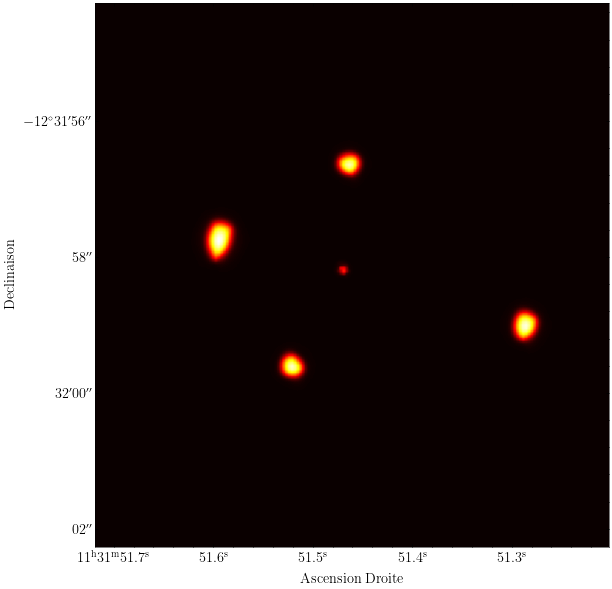

In [1026]:
I = NIE_forward_model(fit.x, intensity, source_grid, lens_grid)
I = convolve2d(I.reshape(im.shape), psf, mode="same")
res = (I)**2

plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(res, origin="lower", cmap="hot", norm=ImageNormalize(stretch=LogStretch()))
ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');

In [1023]:
fit

      fun: 2249.3750780956625
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  2.72848411e-04,  6.82121027e-04, -3.18323146e-04,
       -4.54747351e-05,  4.09272618e-04, -1.63709046e-03,  6.18456397e-02,
       -5.00904207e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 330
      nit: 3
     njev: 33
   status: 0
  success: True
        x: array([ 0.11062561, -0.00965957,  0.29806976,  0.27255073,  0.10086927,
        2.01835254, -0.3       , -0.00296978,  0.0063781 ])

In [1028]:
im.max()

123.906906

In [1029]:
intensity

7070.8555